In [24]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [25]:
t9_0 = 0.2
rho_0 = 1e+3 #g/cc
den_frac = 0.5

In [26]:
t = np.linspace(0,100,1000)
t9 = t9_0*(1 - t9_0*np.sin(2*np.pi*t/10))

rho = den_frac*rho_0*np.power(t9,3)
lambda_decay = 0.001
lambda_excite = 0.001
'''plt.figure(figsize = (13.66,7.68))
plt.rcParams['font.size'] = 18
plt.plot(t,t9)
plt.xlabel('Time (s)')
plt.ylabel(r'$T_{9}$')
plt.figure(figsize = (13.66,7.68))
plt.rcParams['font.size'] = 18
plt.plot(t,rho)
plt.xlabel('Time (s)')
plt.ylabel(r'$\rho$ 10^{3} g/cc')
plt.show()
'''

"plt.figure(figsize = (13.66,7.68))\nplt.rcParams['font.size'] = 18\nplt.plot(t,t9)\nplt.xlabel('Time (s)')\nplt.ylabel(r'$T_{9}$')\nplt.figure(figsize = (13.66,7.68))\nplt.rcParams['font.size'] = 18\nplt.plot(t,rho)\nplt.xlabel('Time (s)')\nplt.ylabel(r'$\rho$ 10^{3} g/cc')\nplt.show()\n"

In [ ]:
def f1(y_85_m_dt,y_85_g_dt,y_85_m,dt,lamda_dec,lambda_ex):
    return y

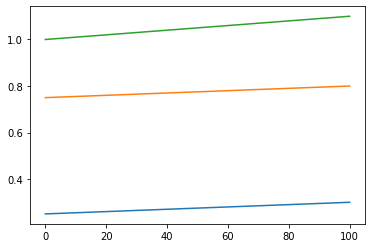

In [27]:
y_kr85g = np.empty(len(t))
y_kr85m = np.empty(len(t))

y_kr85g[0] = 0.75
y_kr85m[0] = 0.25

dt = t[1] - t[0]

for i in range (1,len(t)):
    y_kr85g[i] = y_kr85g[i-1] + dt*(lambda_decay*y_kr85g[i-1] - lambda_excite*y_kr85m[i-1])
    y_kr85m[i] = y_kr85m[i-1] + dt*(lambda_excite*y_kr85g[i-1] - lambda_decay*y_kr85m[i-1])

plt.figure()
plt.plot(t,y_kr85m)
plt.plot(t,y_kr85g)
plt.plot(t,y_kr85g+y_kr85m)
plt.show()